In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

TorchVision Object Detection Finetuning Tutorial
================================================


For this tutorial, we will be finetuning a pre-trained [Mask
R-CNN](https://arxiv.org/abs/1703.06870) model on the [Penn-Fudan
Database for Pedestrian Detection and
Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains
170 images with 345 instances of pedestrians, and we will use it to
illustrate how to use the new features in torchvision in order to train
an object detection and instance segmentation model on a custom dataset.

Defining the Dataset
====================

The reference scripts for training object detection, instance
segmentation and person keypoint detection allows for easily supporting
adding new custom datasets. The dataset should inherit from the standard
`torch.utils.data.Dataset`{.interpreted-text role="class"} class, and
implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__`
should return a tuple:

-   image: `torchvision.tv_tensors.Image`{.interpreted-text
    role="class"} of shape `[3, H, W]`, a pure tensor, or a PIL Image of
    size `(H, W)`
-   target: a dict containing the following fields
    -   `boxes`,
        `torchvision.tv_tensors.BoundingBoxes`{.interpreted-text
        role="class"} of shape `[N, 4]`: the coordinates of the `N`
        bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to
        `W` and `0` to `H`
    -   `labels`, integer `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: the label for each bounding box. `0` represents
        always the background class.
    -   `image_id`, int: an image identifier. It should be unique
        between all the images in the dataset, and is used during
        evaluation
    -   `area`, float `torch.Tensor`{.interpreted-text role="class"} of
        shape `[N]`: the area of the bounding box. This is used during
        evaluation with the COCO metric, to separate the metric scores
        between small, medium and large boxes.
    -   `iscrowd`, uint8 `torch.Tensor`{.interpreted-text role="class"}
        of shape `[N]`: instances with `iscrowd=True` will be ignored
        during evaluation.
    -   (optionally) `masks`,
        `torchvision.tv_tensors.Mask`{.interpreted-text role="class"} of
        shape `[N, H, W]`: the segmentation masks for each one of the
        objects

If your dataset is compliant with above requirements then it will work
for both training and evaluation codes from the reference script.
Evaluation code will use scripts from `pycocotools` which can be
installed with `pip install pycocotools`.

One note on the `labels`. The model considers class `0` as background.
If your dataset does not contain the background class, you should not
have `0` in your `labels`. For example, assuming you have just two
classes, *cat* and *dog*, you can define `1` (not `0`) to represent
*cats* and `2` to represent *dogs*. So, for instance, if one of the
images has both classes, your `labels` tensor should look like `[1, 2]`.

Additionally, if you want to use aspect ratio grouping during training
(so that each batch only contains images with similar aspect ratios),
then it is recommended to also implement a `get_height_and_width`
method, which returns the height and the width of the image. If this
method is not provided, we query all elements of the dataset via
`__getitem__` , which loads the image in memory and is slower than if a
custom method is provided.

Writing a custom dataset for PennFudan
--------------------------------------

Let's write a dataset for the PennFudan dataset. First, let\'s download
the dataset and extract the [zip
file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip):

``` {.sourceCode .python}
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
cd data && unzip PennFudanPed.zip
```

We have the following folder structure:

    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png

Here is one example of a pair of images and segmentation masks


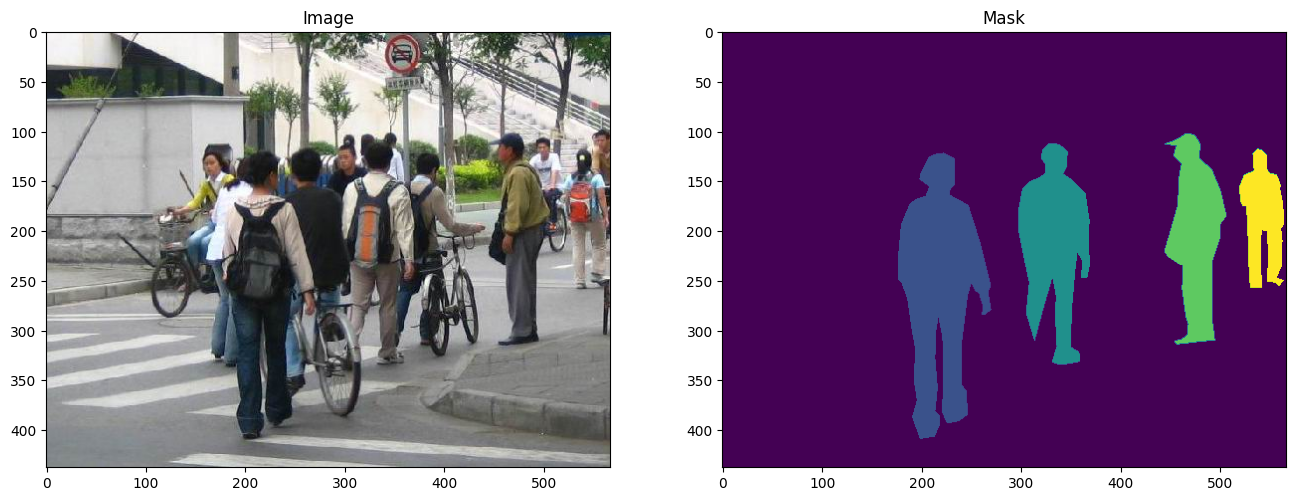

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("Downloads/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("Downloads/PennFudanPed/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))
plt.show()

So each image has a corresponding segmentation mask, where each color
correspond to a different instance. Let's write a
`torch.utils.data.Dataset`{.interpreted-text role="class"} class for
this dataset. In the code below, we are wrapping images, bounding boxes
and masks into `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} classes so that we will be able to apply torchvision
built-in transformations ([new Transforms
API](https://pytorch.org/vision/stable/transforms.html)) for the given
object detection and segmentation task. Namely, image tensors will be
wrapped by `torchvision.tv_tensors.Image`{.interpreted-text
role="class"}, bounding boxes into
`torchvision.tv_tensors.BoundingBoxes`{.interpreted-text role="class"}
and masks into `torchvision.tv_tensors.Mask`{.interpreted-text
role="class"}. As `torchvision.tv_tensors.TVTensor`{.interpreted-text
role="class"} are `torch.Tensor`{.interpreted-text role="class"}
subclasses, wrapped objects are also tensors and inherit the plain
`torch.Tensor`{.interpreted-text role="class"} API. For more information
about torchvision `tv_tensors` see [this
documentation](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#what-are-tvtensors).


In [9]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Now let's define a model that can perform
predictions on this dataset.

Defining your model
===================

In this tutorial, we will be using [Mask
R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of
[Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a
model that predicts both bounding boxes and class scores for potential
objects in the image.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts
segmentation masks for each instance.

![image](https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image04.png)

There are two common situations where one might want to modify one of
the available models in TorchVision Model Zoo. The first is when we want
to start from a pre-trained model, and just finetune the last layer. The
other is when we want to replace the backbone of the model with a
different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.

1 - Finetuning from a pretrained model
--------------------------------------

Let's suppose that you want to start from a model pre-trained on COCO
and want to finetune it for your particular classes. Here is a possible
way of doing it:


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

2 - Modifying the model to add a different backbone
===================================================


In [13]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Object detection and instance segmentation model for PennFudan Dataset
======================================================================

In our case, we want to finetune from a pre-trained model, given that
our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will
be using Mask R-CNN:


In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

That's it, this will make `model` be ready to be trained and evaluated
on your custom dataset.

Putting everything together
===========================

In `references/detection/`, we have a number of helper functions to
simplify training and evaluating detection models. Here, we will use
`references/detection/engine.py` and `references/detection/utils.py`.
Just download everything under `references/detection` to your folder and
use them here. On Linux if you have `wget`, you can download them using
below commands:


In [7]:
!pip install requests
import requests

urls = [
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py",
    "https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
]

for url in urls:
    filename = url.split("/")[-1]
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download: {filename}, Status code: {response.status_code}")


Downloaded: engine.py
Downloaded: utils.py
Downloaded: coco_utils.py
Downloaded: coco_eval.py
Downloaded: transforms.py


Since v0.15.0 torchvision provides [new Transforms
API](https://pytorch.org/vision/stable/transforms.html) to easily write
data augmentation pipelines for Object Detection and Segmentation tasks.

Let's write some helper functions for data augmentation /
transformation:


In [17]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Testing `forward()` method (Optional)
=====================================

Before iterating over the dataset, it\'s good to see what the model
expects during training and inference time on sample data.


In [23]:
import os
print(os.getcwd())

import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

C:\Users\Sky
{'loss_classifier': tensor(0.1736, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0672, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0059, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0032, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let's now write the main function which performs the training and the
validation:


In [42]:

from utils import *
from engine import train_one_epoch, evaluate
import torch


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

cpu
Epoch: [0]  [ 0/60]  eta: 0:03:15  lr: 0.000090  loss: 3.9273 (3.9273)  loss_classifier: 0.5522 (0.5522)  loss_box_reg: 0.1339 (0.1339)  loss_mask: 3.2248 (3.2248)  loss_objectness: 0.0153 (0.0153)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 3.2588  data: 0.0120
Epoch: [0]  [10/60]  eta: 0:03:17  lr: 0.000936  loss: 1.7856 (2.4148)  loss_classifier: 0.3848 (0.3906)  loss_box_reg: 0.2016 (0.2578)  loss_mask: 1.0643 (1.7454)  loss_objectness: 0.0146 (0.0169)  loss_rpn_box_reg: 0.0032 (0.0041)  time: 3.9525  data: 0.0171
Epoch: [0]  [20/60]  eta: 0:02:33  lr: 0.001783  loss: 0.9167 (1.5947)  loss_classifier: 0.2158 (0.2733)  loss_box_reg: 0.2229 (0.2576)  loss_mask: 0.2960 (1.0420)  loss_objectness: 0.0146 (0.0176)  loss_rpn_box_reg: 0.0032 (0.0042)  time: 3.8723  data: 0.0144
Epoch: [0]  [30/60]  eta: 0:01:58  lr: 0.002629  loss: 0.5955 (1.2649)  loss_classifier: 0.1083 (0.2111)  loss_box_reg: 0.2448 (0.2573)  loss_mask: 0.2398 (0.7766)  loss_objectness: 0.0060 (0.0147)  loss_rpn_box_r

So after one epoch of training, we obtain a COCO-style mAP \> 50, and a
mask mAP of 65.

But what do the predictions look like? Let's take one image in the
dataset and verify


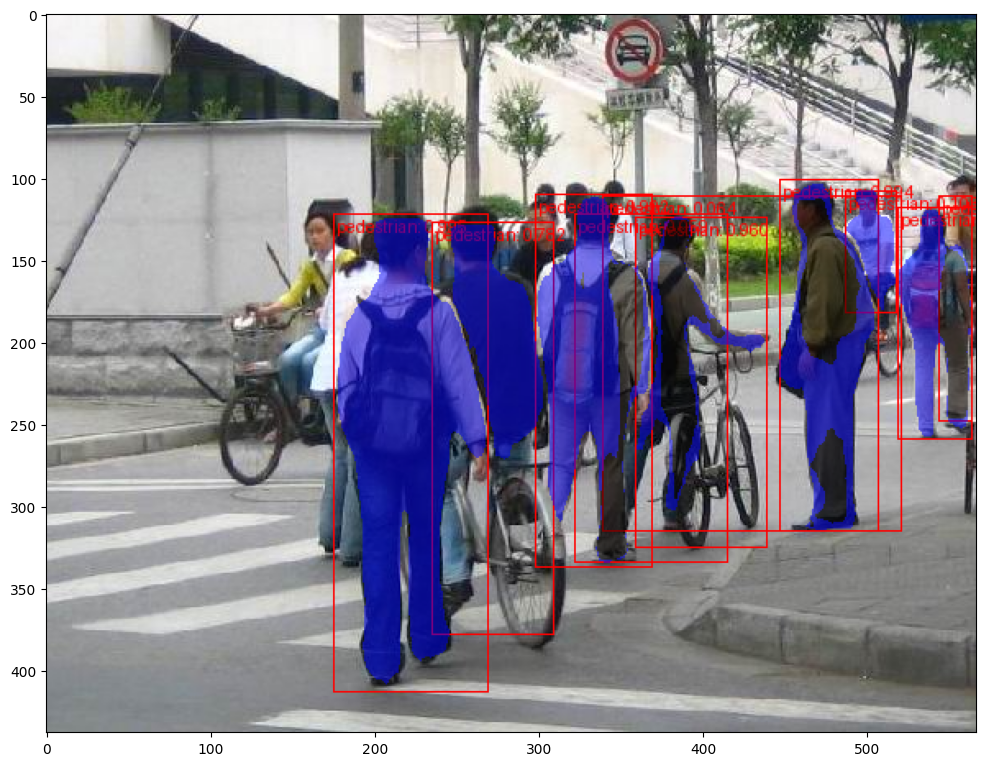

In [44]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("Downloads/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()

# Implementation of Training another model (model2) with option2, a different backbone

In [40]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import models
from torchvision.models import resnet50
import torch.nn as nn

# 1. Load a pre-trained ResNet-50 model as the backbone
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model2 = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)


# Reuse the training in option 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model2.to(device)

dataset = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=False))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model2, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model2, data_loader_test, device=device)
print("That's it!")

Epoch: [0]  [ 0/85]  eta: 0:05:57  lr: 0.000064  loss: 1.4703 (1.4703)  loss_classifier: 0.6877 (0.6877)  loss_box_reg: 0.0408 (0.0408)  loss_objectness: 0.6924 (0.6924)  loss_rpn_box_reg: 0.0494 (0.0494)  time: 4.2085  data: 0.0125
Epoch: [0]  [10/85]  eta: 0:05:02  lr: 0.000659  loss: 1.3922 (1.4011)  loss_classifier: 0.6617 (0.6344)  loss_box_reg: 0.0408 (0.0434)  loss_objectness: 0.6847 (0.6826)  loss_rpn_box_reg: 0.0368 (0.0407)  time: 4.0306  data: 0.0118
Epoch: [0]  [20/85]  eta: 0:04:20  lr: 0.001254  loss: 1.2415 (1.2378)  loss_classifier: 0.4661 (0.4892)  loss_box_reg: 0.0527 (0.0577)  loss_objectness: 0.6561 (0.6524)  loss_rpn_box_reg: 0.0328 (0.0385)  time: 4.0030  data: 0.0121
Epoch: [0]  [30/85]  eta: 0:03:35  lr: 0.001848  loss: 0.9373 (1.1264)  loss_classifier: 0.2582 (0.4096)  loss_box_reg: 0.0768 (0.0787)  loss_objectness: 0.5685 (0.6009)  loss_rpn_box_reg: 0.0341 (0.0372)  time: 3.8689  data: 0.0124
Epoch: [0]  [40/85]  eta: 0:02:55  lr: 0.002443  loss: 0.8812 (1.074

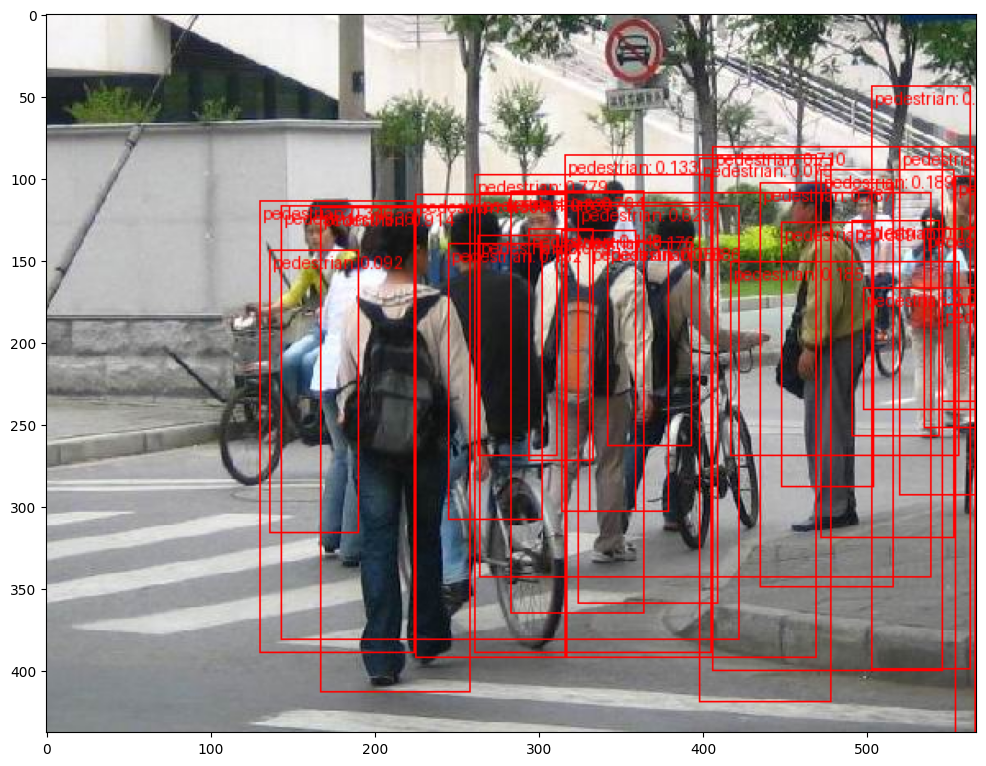

In [43]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("Downloads/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model2.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model2([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()

# Comparison of result

## Option 1

### **The fine-tuned model detects bounding boxes, but the density is visibly reduced compared to option 2. And it seems identifies the object more accurately and the noise is lower. This is because this model makes use of segmentation masks, making it easier to visually distinguish each person, and the bounding boxes are fewer, which might be a result of more improved feature extraction.**

# Option 2

### **The backbone substitution solution detects a large number of bounding boxes around the pedestrians. There are many overlapping boxes, which makes it difficult to clearly distinguish individual instances. This might be due to the lack of incorporation of masked images. Therefore, I trained a new model with different backbone but also incorporates Masked segementation.**

In [35]:
!pip install pycocotools
import torch
import torchvision
from torchvision.models.detection import FasterRCNN, MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import models
from torchvision.models import resnet50
import torch.nn as nn
from engine import train_one_epoch, evaluate
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and person
num_classes = 2

# use our dataset and defined transformations
dataset = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('Downloads/PennFudanPed/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# Modify the Mask R-CNN model to use MobileNetV2 as the backbone
def get_model_instance_segmentation_with_mobilenet(num_classes):
    # Load the pre-trained MobileNetV2 model as the backbone
    backbone = models.mobilenet_v2(weights="DEFAULT").features

    # Mask R-CNN needs to know the number of output channels in the backbone
    # For MobileNetV2, it's 1280, which is the output channel size of the last layer
    backbone.out_channels = 1280

    # Define the AnchorGenerator for the Region Proposal Network (RPN)
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # Define the RoI Pooling
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2
    )

    # Put together the Mask R-CNN model using the new backbone
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    # Replace the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor with the correct number of classes
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

# Get the Mask R-CNN model with MobileNetV2 as the backbone
model3 = get_model_instance_segmentation_with_mobilenet(num_classes)

# Move model to the appropriate device
model3.to(device)

# Construct an optimizer
params = [p for p in model3.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Train the model for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    model3.train()  # Set model to training mode
    train_one_epoch(model3, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()  # Update the learning rate

    # Evaluate on the test dataset
    model3.eval()  # Set model to evaluation mode
    evaluate(model3, data_loader_test, device=device)

print("That's it!")


  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/2e/f5/dfa78dc72e47dfe1ada7b37fedcb338454750470358a6dfcfdfda35fa337/pycocotools-2.0.8-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/85.3 kB ? eta -:--:--
   ------------------- -------------------- 41.0/85.3 kB 991.0 kB/s eta 0:00:01
   ---------------------------------------- 85.3/85.3 kB 1.6 MB/s eta 0:00:00
cuda


C:\Users\Sky\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


NotImplementedError: Could not run 'torchvision::nms' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'torchvision::nms' is only available for these backends: [CPU, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\cpu\nms_kernel.cpp:112 [kernel]
Meta: registered at /dev/null:154 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\quantized\cpu\qnms_kernel.cpp:124 [kernel]
BackendSelect: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:34 [kernel]
AutocastXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:351 [backend fallback]
AutocastCUDA: registered at C:\actions-runner\_work\vision\vision\pytorch\vision\torchvision\csrc\ops\autocast\nms_kernel.cpp:27 [kernel]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]


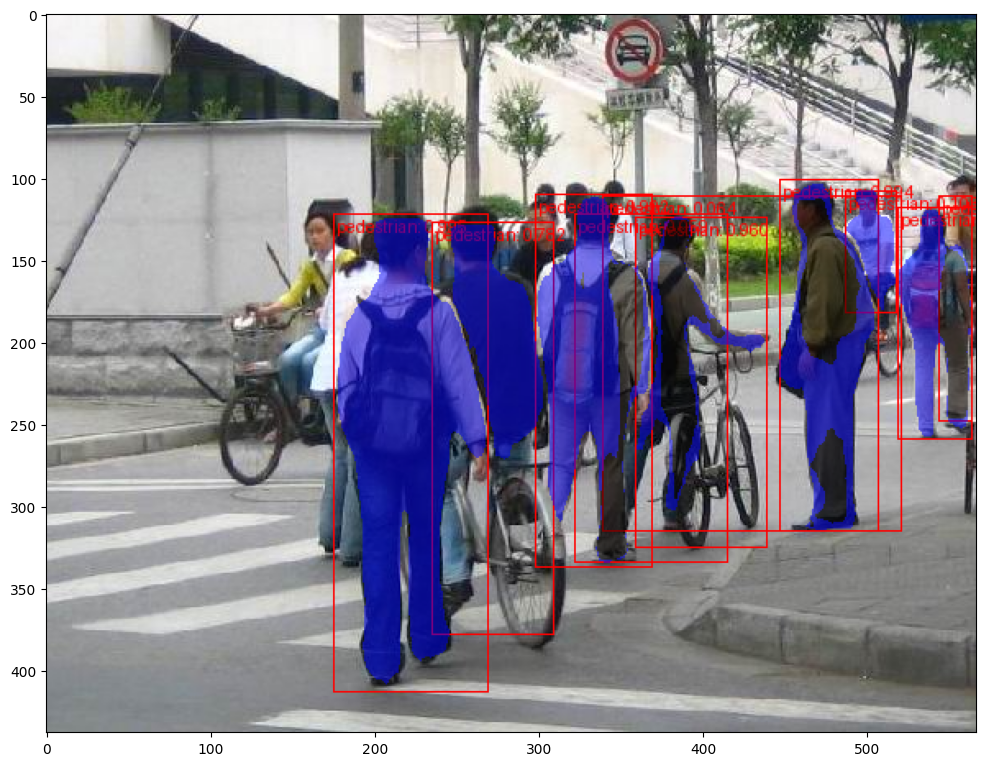

In [50]:
image = read_image("Downloads/PennFudanPed/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()

The results look good!

Wrapping up
===========

In this tutorial, you have learned how to create your own training
pipeline for object detection models on a custom dataset. For that, you
wrote a `torch.utils.data.Dataset`{.interpreted-text role="class"} class
that returns the images and the ground truth boxes and segmentation
masks. You also leveraged a Mask R-CNN model pre-trained on COCO
train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-GPU
training, check `references/detection/train.py`, which is present in the
torchvision repository.
